In [1]:
import pandas as pd
import torch
from torch.nn import Linear
import torch.nn.functional as F
import numpy as np
import torch_geometric
from torch_geometric.data import Data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from torch_geometric.nn.norm import LayerNorm
from pathlib import Path

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [17]:
dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())
data = dataset[0]

In [18]:
data

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])

In [19]:
data.train_mask.sum()

tensor(60)

In [20]:
data.val_mask.sum()

tensor(500)

In [21]:
data.test_mask.sum()

tensor(1000)

In [22]:
rf_model = RandomForestClassifier(
    n_estimators=5,
    max_depth=50,
    random_state=1105
)

rf_model.fit(data.x[data.train_mask], data.y[data.train_mask])
y_pred = rf_model.predict(data.x[data.test_mask])
y_true = data.y[data.test_mask].numpy()

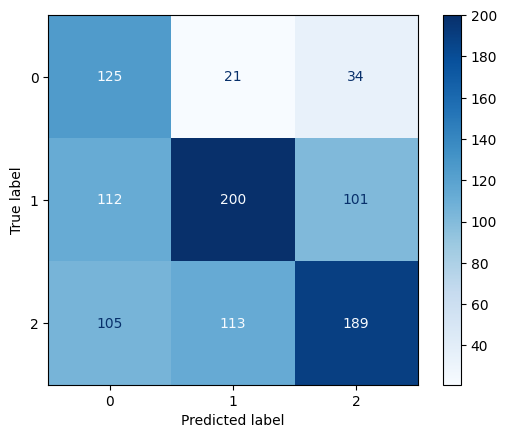

Accuracy: 0.5140
Precision: 0.5159
Recall: 0.5477
f1 score: 0.5105


In [23]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred, average='macro'):.4f}")

In [24]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    random_state=1105
)

lr_model.fit(data.x[data.train_mask], data.y[data.train_mask])
y_pred = lr_model.predict(data.x[data.test_mask])
y_true = data.y[data.test_mask].numpy()

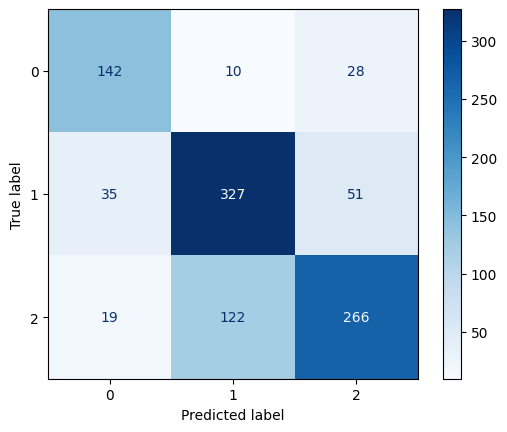

Accuracy: 0.7350
Precision: 0.7360
Recall: 0.7447
f1 score: 0.7376


In [25]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred, average='macro'):.4f}")

In [26]:
from sklearn.svm import LinearSVC

class_weight = {
    0: 1.0,
    1: 4.0
}
svc_model = LinearSVC(
    class_weight=class_weight,
    random_state=1105
)

svc_model.fit(data.x[data.train_mask], data.y[data.train_mask])
y_pred = svc_model.predict(data.x[data.test_mask])
y_true = data.y[data.test_mask].numpy()

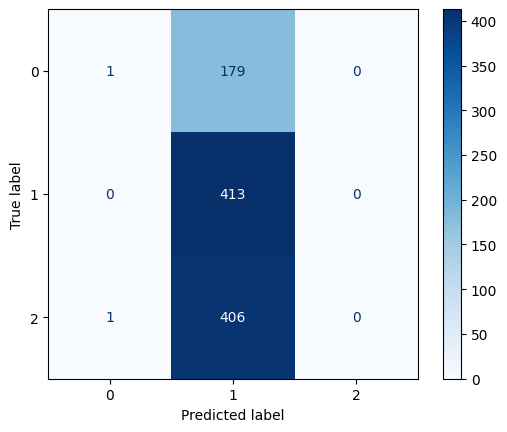

Accuracy: 0.4140
Precision: 0.3046
Recall: 0.3352
f1 score: 0.1988


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred, average='macro'):.4f}")

In [28]:
def count_parameters(params):
    num = sum(p.numel() for p in params if p.requires_grad)
    print(f"{num:,}")
    return num

In [31]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(data.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels * 2)
        self.lin3 = Linear(hidden_channels * 2, hidden_channels * 4)
        self.lin4 = Linear(hidden_channels * 4, hidden_channels * 8)
        self.lin5 = Linear(hidden_channels * 8, hidden_channels * 4)
        self.lin6 = Linear(hidden_channels * 4, hidden_channels * 2)
        self.lin7 = Linear(hidden_channels * 2, dataset.num_classes)
        self.norm1 = torch.nn.LayerNorm(hidden_channels)
        self.norm2 = torch.nn.LayerNorm(hidden_channels * 2)
        self.norm3 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm4 = torch.nn.LayerNorm(hidden_channels * 8)
        self.norm5 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm6 = torch.nn.LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.lin1(x)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin4(x)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin5(x)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin6(x)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin7(x)
        # x = self.log_softmax(x)
        # x = x.squeeze()
        return x
    
model = MLP(hidden_channels=64)
print(f"MLP model number of params: {count_parameters(model.parameters()):,}")

372,291
MLP model number of params: 372,291


In [32]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
# criterion = torch.nn.BCEWithLogitsLoss()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 100
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    X_tmp = data.x[data.train_mask]
    y_tmp = data.y[data.train_mask]
    preds = model(X_tmp)  # Perform a single forward pass.
    loss = criterion(preds, y_tmp)  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_X_tmp = data.x[data.val_mask]
        v_y_tmp = data.y[data.val_mask]
        v_preds = model(v_X_tmp)
        v_loss = criterion(v_preds, v_y_tmp)
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 1.1099 / Val_loss: 1.1347
Epoch: 002, Train_loss: 1.0697 / Val_loss: 1.1076
Epoch: 003, Train_loss: 1.1558 / Val_loss: 1.1236
Epoch: 004, Train_loss: 1.1143 / Val_loss: 1.1549
Epoch: 005, Train_loss: 1.1592 / Val_loss: 1.1923
Epoch: 006, Train_loss: 1.0797 / Val_loss: 1.2135
Epoch: 007, Train_loss: 1.1327 / Val_loss: 1.2344
Epoch: 008, Train_loss: 1.2058 / Val_loss: 1.2558
Epoch: 009, Train_loss: 1.2350 / Val_loss: 1.2632
Epoch: 010, Train_loss: 1.2002 / Val_loss: 1.2654
Epoch: 011, Train_loss: 1.1590 / Val_loss: 1.2575
Epoch: 012, Train_loss: 1.1795 / Val_loss: 1.2340
Epoch: 013, Train_loss: 1.1724 / Val_loss: 1.2127
Epoch: 014, Train_loss: 1.2414 / Val_loss: 1.1921
Epoch: 015, Train_loss: 1.2082 / Val_loss: 1.1724
Epoch: 016, Train_loss: 1.2241 / Val_loss: 1.1557
Epoch: 017, Train_loss: 1.2274 / Val_loss: 1.1406
Epoch: 018, Train_loss: 1.1332 / Val_loss: 1.1273
Epoch: 019, Train_loss: 1.1649 / Val_loss: 1.1159
Epoch: 020, Train_loss: 1.2079 / Val_loss: 1.1048


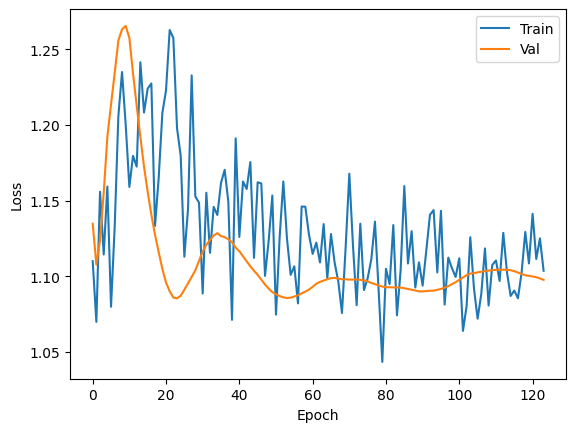

In [33]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

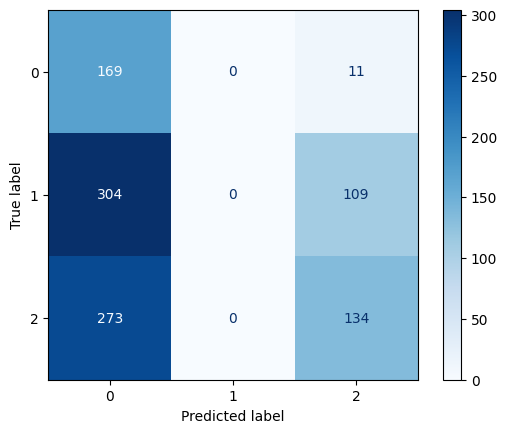

Accuracy: 0.4140
Precision: 0.3046
Recall: 0.3352
f1 score: 0.1988


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
model.eval()
X_tmp_test = data.x[data.test_mask]
y_tmp_test = data.y[data.test_mask]
with torch.no_grad():
    out = model(X_tmp_test)
pred = out.argmax(dim=1)  # Use the class with highest probability.

cm = confusion_matrix(y_tmp_test, pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred, average='macro'):.4f}")

In [35]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GCNConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GCNConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GCNConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GCNConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GCNConv(hidden_channels * 2, dataset.num_classes)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        # x = x.squeeze()
        # x = self.log_softmax(x)
        return x

model = GCN(hidden_channels=64)
print(f"GCN model number of params: {count_parameters(model.parameters()):,}")

372,291
GCN model number of params: 372,291


In [36]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 100
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 1.5599 / Val_loss: 1.5974
Epoch: 002, Train_loss: 1.5992 / Val_loss: 1.4511
Epoch: 003, Train_loss: 1.3659 / Val_loss: 1.3512
Epoch: 004, Train_loss: 1.1935 / Val_loss: 1.2535
Epoch: 005, Train_loss: 1.1792 / Val_loss: 1.2271
Epoch: 006, Train_loss: 1.1292 / Val_loss: 1.1769
Epoch: 007, Train_loss: 1.0825 / Val_loss: 1.2191
Epoch: 008, Train_loss: 1.0920 / Val_loss: 1.1580
Epoch: 009, Train_loss: 1.1760 / Val_loss: 1.1692
Epoch: 010, Train_loss: 1.0715 / Val_loss: 1.1728
Epoch: 011, Train_loss: 1.0670 / Val_loss: 1.1018
Epoch: 012, Train_loss: 0.9672 / Val_loss: 1.1515
Epoch: 013, Train_loss: 0.9341 / Val_loss: 1.1004
Epoch: 014, Train_loss: 1.0336 / Val_loss: 1.1029
Epoch: 015, Train_loss: 0.9315 / Val_loss: 1.0809
Epoch: 016, Train_loss: 0.9892 / Val_loss: 1.0801
Epoch: 017, Train_loss: 0.9715 / Val_loss: 1.0637
Epoch: 018, Train_loss: 0.9009 / Val_loss: 1.0575
Epoch: 019, Train_loss: 0.9738 / Val_loss: 1.0465
Epoch: 020, Train_loss: 0.8244 / Val_loss: 1.0368


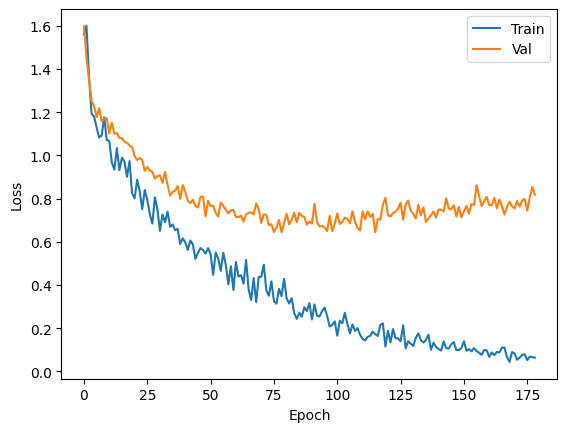

In [37]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [38]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)  # Use the class with highest probability.

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

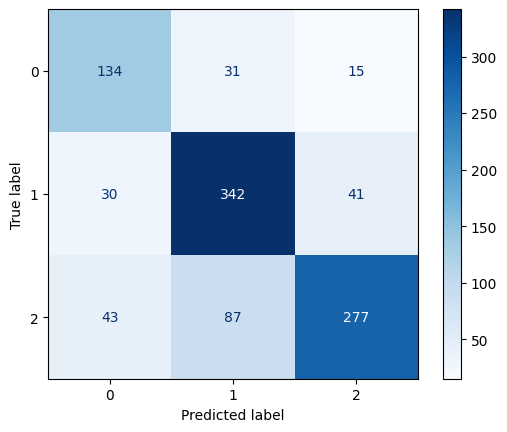

Accuracy: 0.7530
Precision: 0.7409
Recall: 0.7510
f1 score: 0.7416


In [39]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred, average='macro'):.4f}")

In [40]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(data.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GATConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GATConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GATConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GATConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GATConv(hidden_channels * 2, dataset.num_classes)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        # x = self.log_softmax(x)
        # x = x.squeeze()
        return x


model = GAT(hidden_channels=64)
print(f"GAT model number of params: {count_parameters(model.parameters()):,}")

374,985
GAT model number of params: 374,985


In [41]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight) # Define loss criterion.
# criterion = torch.nn.BCEWithLogitsLoss()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 1.5076 / Val_loss: 1.3649
Epoch: 002, Train_loss: 1.4392 / Val_loss: 1.3057
Epoch: 003, Train_loss: 1.3331 / Val_loss: 1.2869
Epoch: 004, Train_loss: 1.3346 / Val_loss: 1.3199
Epoch: 005, Train_loss: 1.3566 / Val_loss: 1.2879
Epoch: 006, Train_loss: 1.3223 / Val_loss: 1.2931
Epoch: 007, Train_loss: 1.3124 / Val_loss: 1.2398
Epoch: 008, Train_loss: 1.1804 / Val_loss: 1.2145
Epoch: 009, Train_loss: 1.2424 / Val_loss: 1.5359
Epoch: 010, Train_loss: 1.3457 / Val_loss: 1.3084
Epoch: 011, Train_loss: 1.1399 / Val_loss: 1.2404
Epoch: 012, Train_loss: 1.3141 / Val_loss: 1.2890
Epoch: 013, Train_loss: 1.2961 / Val_loss: 1.3017
Epoch: 014, Train_loss: 1.2612 / Val_loss: 1.4427
Epoch: 015, Train_loss: 1.1982 / Val_loss: 1.3053
Epoch: 016, Train_loss: 1.3141 / Val_loss: 1.3107
Epoch: 017, Train_loss: 1.1681 / Val_loss: 1.2951
Epoch: 018, Train_loss: 1.2326 / Val_loss: 1.2848
Epoch: 019, Train_loss: 1.2747 / Val_loss: 1.3368
Epoch: 020, Train_loss: 1.2293 / Val_loss: 1.2963


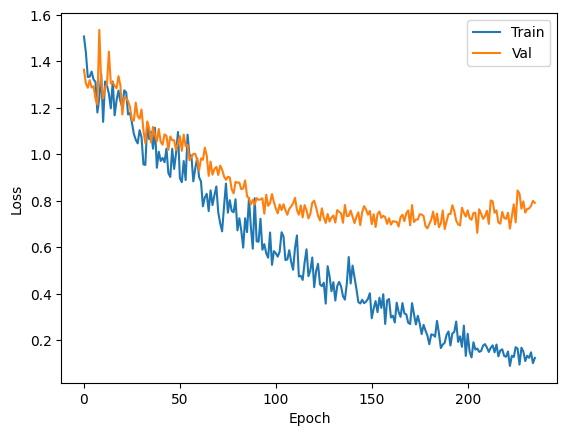

In [42]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [43]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
# pred = F.sigmoid(out).round()
pred = out.argmax(dim=1)  # Use the class with highest probability.

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

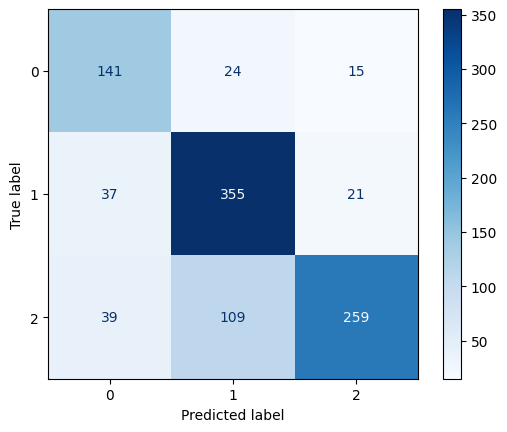

Accuracy: 0.7550
Precision: 0.7517
Recall: 0.7598
f1 score: 0.7454


In [44]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred, average='macro'):.4f}")